# PART 1: Comparative EDA & Feature Engineering


This section performs a full Exploratory Data Analysis, comparing Mud Pump A and B across multiple dimensions before engineering features for modeling.


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)
pd.set_option('display.max_columns', None)


## 1.1. Load Data


In [45]:
df_a_original = pd.read_csv('datasets/Mud Pump A Data.csv', parse_dates=['Datetime'])
df_b_original = pd.read_csv('datasets/Mud Pump B Data.csv', parse_dates=['Datetime'])
print("--- Pump A Original Data Head ---")
df_a_original.head()

/tmp/ipykernel_65936/3801660069.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_a_original = pd.read_csv('datasets/Mud Pump A Data.csv', parse_dates=['Datetime'])
/tmp/ipykernel_65936/3801660069.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_b_original = pd.read_csv('datasets/Mud Pump B Data.csv', parse_dates=['Datetime'])


--- Pump A Original Data Head ---


,Datetime,Mud Pump A,React 55 Mud Flow to Mud Pump A,MUD PUMP A SUCTION PRESS,MUD PUMP A SPEED,MUD PUMP A SPEED.1,PUM-34A- Current,Mud pump A speed,MUD PUMP A CYLINDER 2,MUD PUMP A CYLINDER 3,Mud Pump A Cylinder #1 Temperature,Mud Pump A Cylinder #2 Temperature,Mud Pump A Cylinder #3 Temperature,Mud Pump A Cylinder #4 Temperature
0,2024-09-03 00:00:00,RUN,105.13,387.84,42.00,99.40,262.89,41.45,6773.16,6795.82,62.21,52.91,59.37,57.87
1,2024-09-03 01:00:00,RUN,145.44,434.91,42.05,99.32,268.08,41.45,7006.63,7035.89,61.64,51.34,59.75,58.15
2,2024-09-03 02:00:00,RUN,140.59,424.09,41.96,99.47,265.45,41.45,6818.97,6843.67,61.43,52.12,60.37,58.98
3,2024-09-03 03:00:00,RUN,148.38,423.87,42.01,99.36,270.20,41.45,6922.45,6951.88,61.10,49.37,59.97,58.11
4,2024-09-03 04:00:00,RUN,140.21,425.91,41.95,99.50,269.51,41.45,6925.41,6958.68,61.52,50.28,61.68,58.28


In [46]:
print("\n--- Pump B Original Data Head ---")
df_b_original.head()


--- Pump B Original Data Head ---


,Datetime,Mud Pump B,MUD PUMP B SLEECTED PRESSURE,MUD PUMP B SPEED,MUD PUMP B SPEED.1,Mud Pump B Current,MUD PUMP B SPEED.2,MUD PUMP B CYLINDER 1,MUD PUMP B CYLINDER 3,Mud Pump B Cylinder #1 Temperature,Mud Pump B Cylinder #2 Temperature,Mud Pump B Cylinder #3 Temperature,Mud Pump B Cylinder #4 Temperature
0,2024-09-03 00:00:00,RUN,6803.47,41.92,99.17,32.06,41.92,6910.42,6847.71,52.75,48.63,59.89,46.25
1,2024-09-03 01:00:00,RUN,7042.43,41.88,99.21,32.93,41.88,7148.24,7089.49,50.40,44.44,59.48,44.47
2,2024-09-03 02:00:00,RUN,6846.34,42.20,98.95,29.46,42.20,6954.51,6895.80,50.53,44.12,59.56,44.06
3,2024-09-03 03:00:00,RUN,6943.65,41.85,99.23,31.20,41.85,7060.83,6998.97,50.74,44.42,60.18,45.22
4,2024-09-03 04:00:00,RUN,6954.20,42.29,98.88,31.65,42.29,7071.47,7010.40,51.88,45.93,60.76,45.41


## 1.2. Standardize Columns


In [47]:
def standardize_columns(df, pump_prefix):
    df_clean = df.copy()
    mapping = {'MUD PUMP A SUCTION PRESS': 'Suction Pressure', 'MUD PUMP B SLEECTED PRESSURE': 'Suction Pressure', 'PUM-34A- Current': 'Current', 'Mud Pump B Current': 'Current'}
    df_clean.rename(columns=mapping, inplace=True)
    new_cols = []
    for col in df_clean.columns:
        new_name = col
        prefixes = [f"MUD PUMP {pump_prefix} ", f"Mud Pump {pump_prefix} ", f"Mud pump {pump_prefix} "]
        for p in prefixes:
            if new_name.upper().startswith(p.upper()): new_name = new_name[len(p):]
        new_name = new_name.replace("Cylinder #", "Cylinder ").replace("CYLINDER ", "Cylinder ").strip()
        new_cols.append(new_name)
    df_clean.columns = new_cols
    df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]
    df_clean['Pump'] = f'Pump {pump_prefix}'
    return df_clean

df_a_clean = standardize_columns(df_a_original, 'A')
df_b_clean = standardize_columns(df_b_original, 'B')
common_cols = sorted(list(set(df_a_clean.columns) & set(df_b_clean.columns)))
df_combined = pd.concat([df_a_clean[common_cols], df_b_clean[common_cols]], ignore_index=True)

print("--- Combined Data Head (for EDA) ---")
df_combined.head()

--- Combined Data Head (for EDA) ---


,Current,Cylinder 1 Temperature,Cylinder 2 Temperature,Cylinder 3,Cylinder 3 Temperature,Cylinder 4 Temperature,Datetime,Pump,SPEED,SPEED.1,Suction Pressure
0,262.89,62.21,52.91,6795.82,59.37,57.87,2024-09-03 00:00:00,Pump A,42.00,99.40,387.84
1,268.08,61.64,51.34,7035.89,59.75,58.15,2024-09-03 01:00:00,Pump A,42.05,99.32,434.91
2,265.45,61.43,52.12,6843.67,60.37,58.98,2024-09-03 02:00:00,Pump A,41.96,99.47,424.09
3,270.20,61.10,49.37,6951.88,59.97,58.11,2024-09-03 03:00:00,Pump A,42.01,99.36,423.87
4,269.51,61.52,50.28,6958.68,61.68,58.28,2024-09-03 04:00:00,Pump A,41.95,99.50,425.91


## 1.3. EDA: Comparative Statistics


In [48]:
numeric_cols = df_combined.select_dtypes(include=[np.number]).columns.tolist()
stats = df_combined.groupby('Pump')[numeric_cols].describe().T
print(stats)

Pump                               Pump A       Pump B
Cylinder 1 Temperature count  8785.000000  8785.000000
                       mean     49.774731    39.721980
                       std      17.329280    16.687432
                       min       3.520000     3.740000
                       25%      52.710000    19.500000
                       50%      57.760000    48.520000
                       75%      59.870000    52.180000
                       max      86.100000    77.710000
Cylinder 2 Temperature count  8785.000000  8785.000000
                       mean     46.389478    36.546890
                       std      16.075967    14.915961
                       min       3.560000     3.080000
                       25%      46.490000    19.190000
                       50%      52.590000    44.060000
                       75%      57.200000    47.710000
                       max      85.480000    78.070000
Cylinder 3             count  8785.000000  8785.000000
          

## 1.4. EDA: Distribution Plots


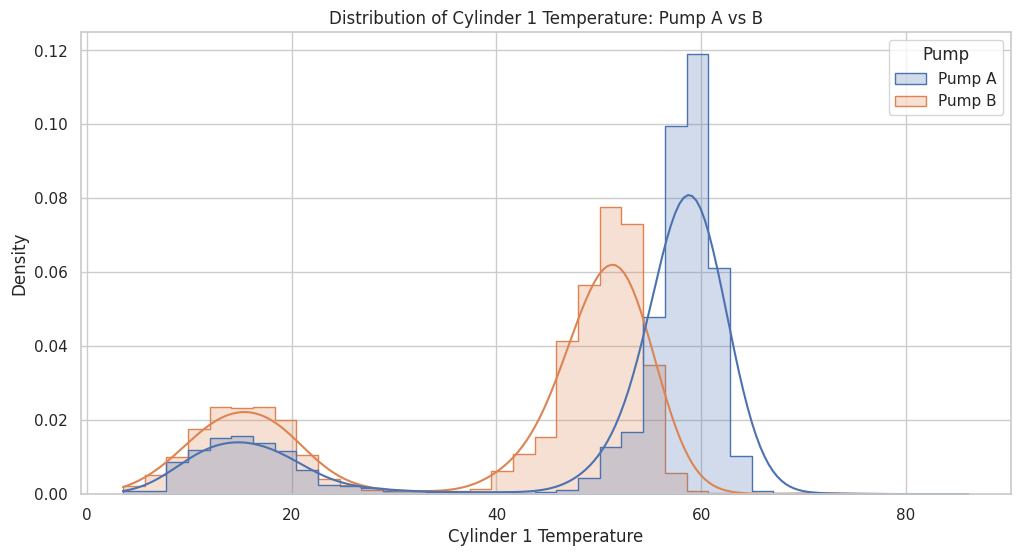

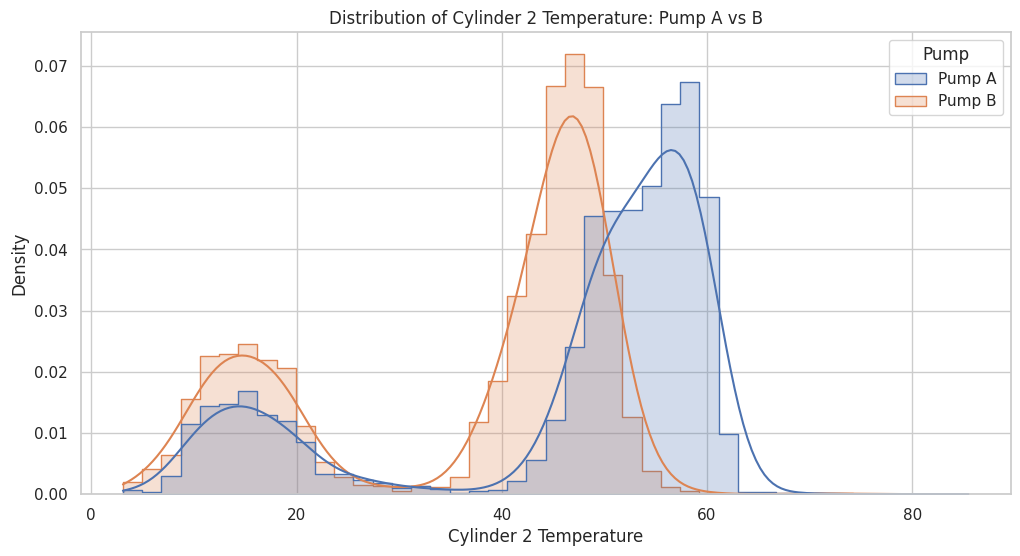

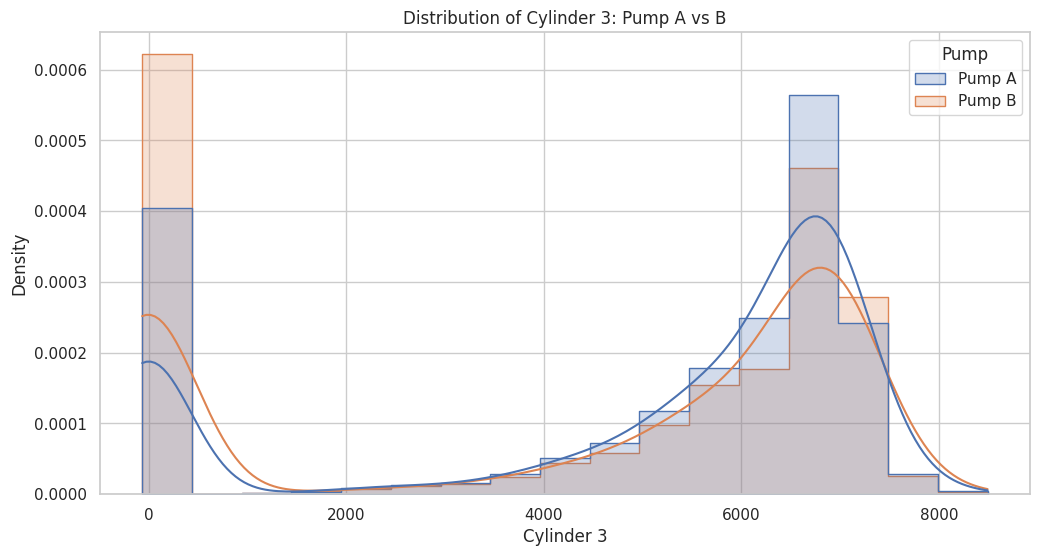

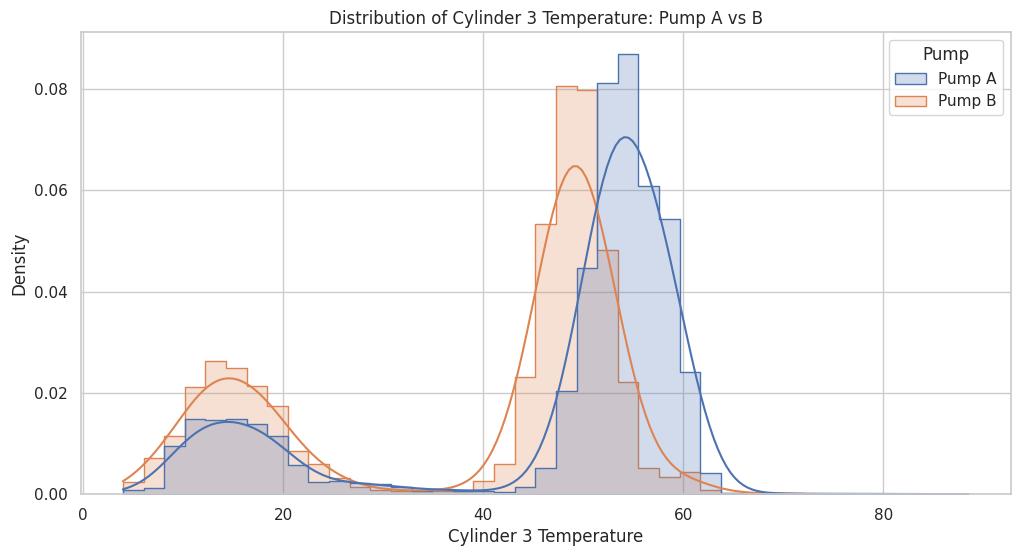

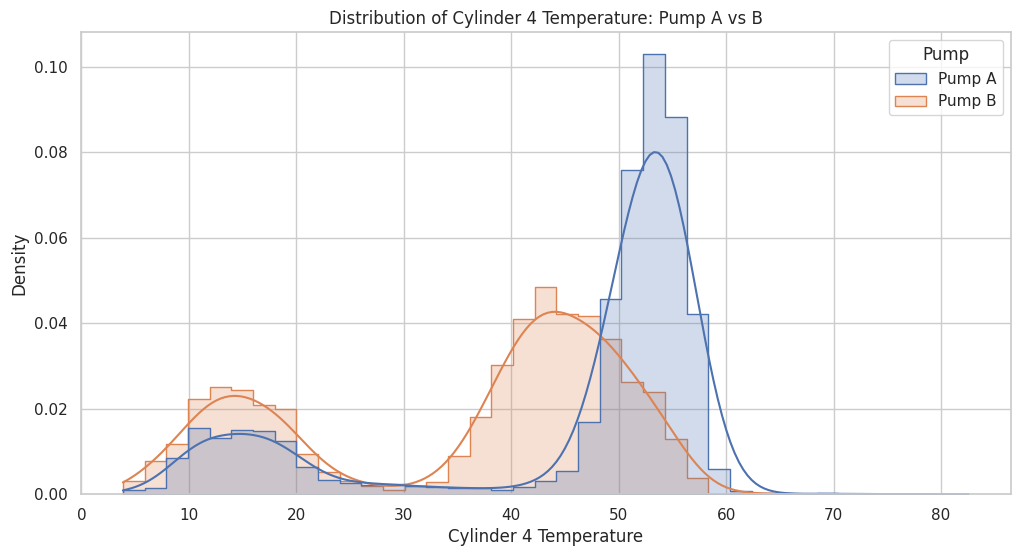

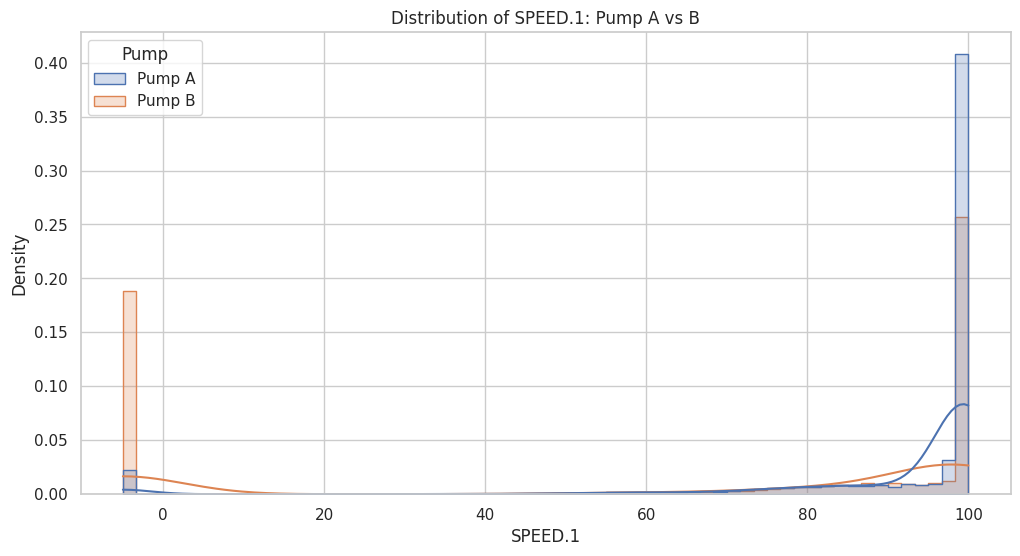

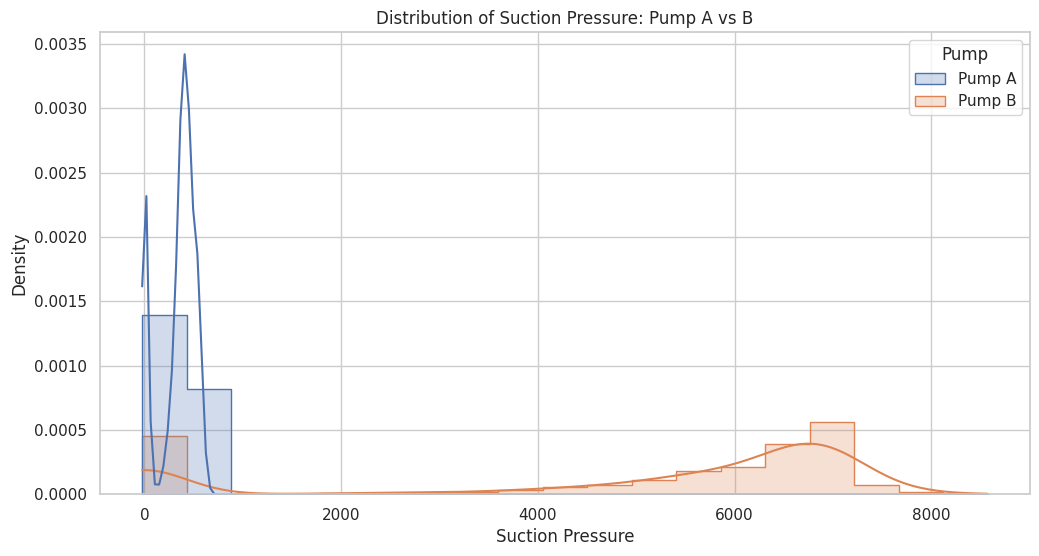

In [49]:
def plot_distribution(feature):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_combined, x=feature, hue='Pump', kde=True, element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {feature}: Pump A vs B')
    plt.show()

for col in numeric_cols:
    plot_distribution(col)



## 1.5. EDA: Feature History Over Time


Plotting the raw values of each feature over time helps us identify trends, shifts in operation, and potential anomalies.


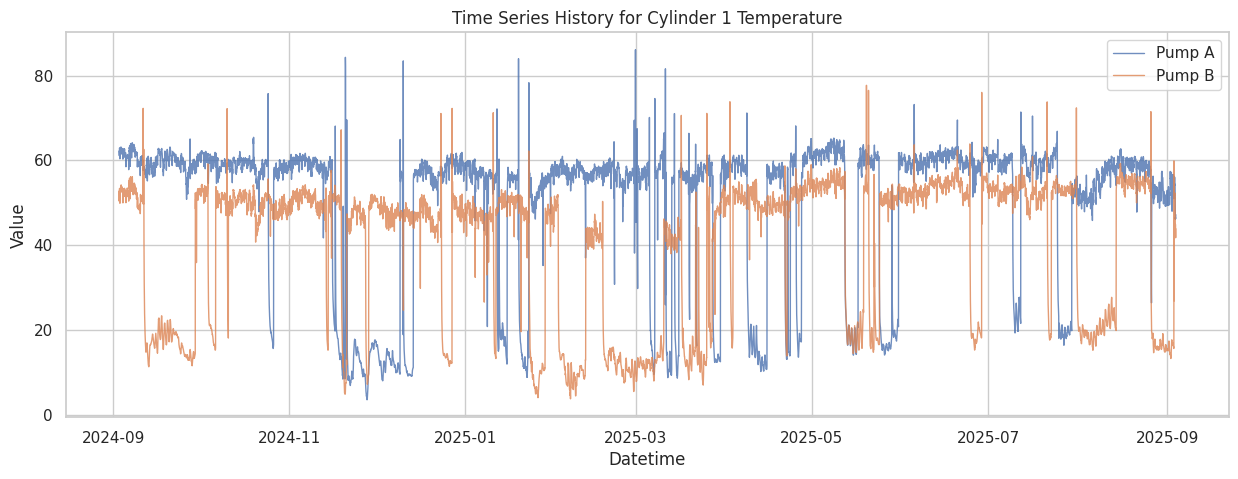

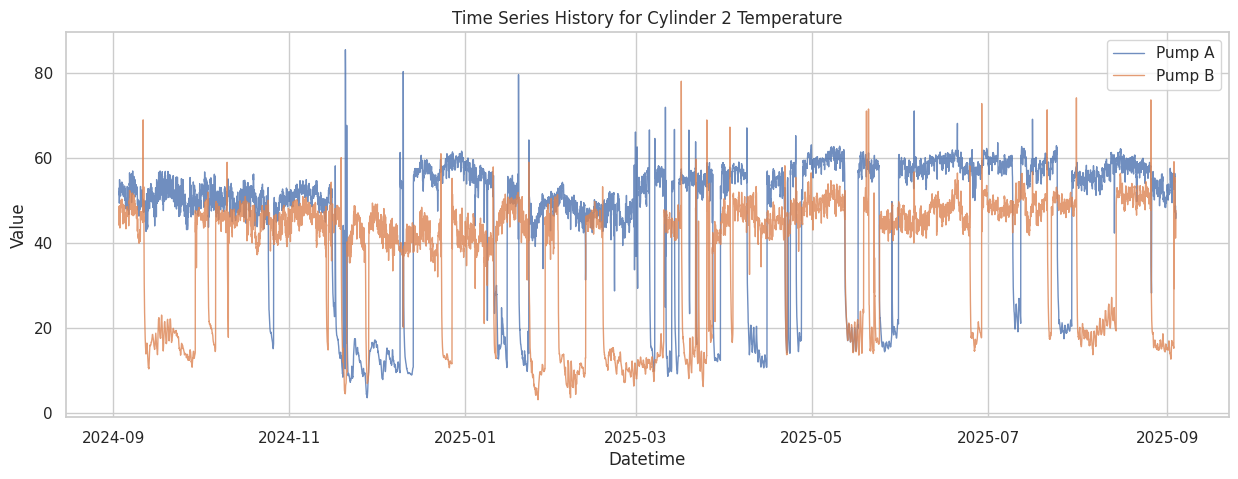

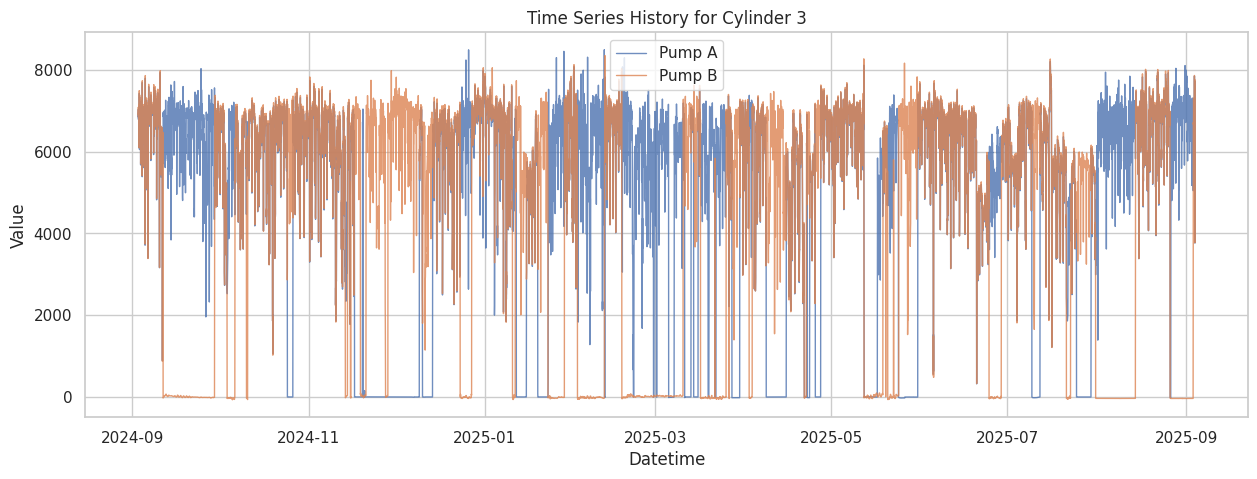

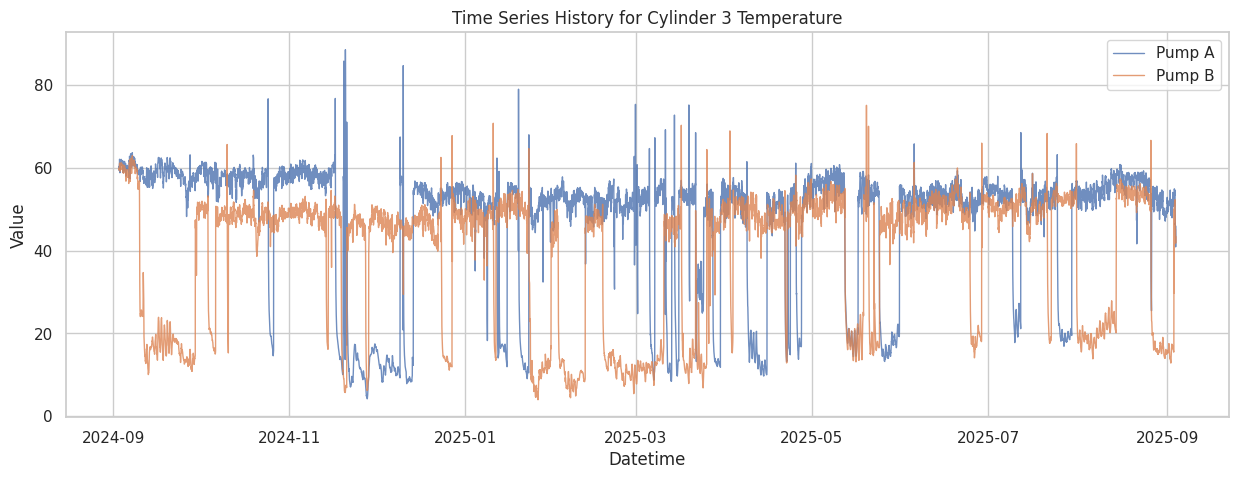

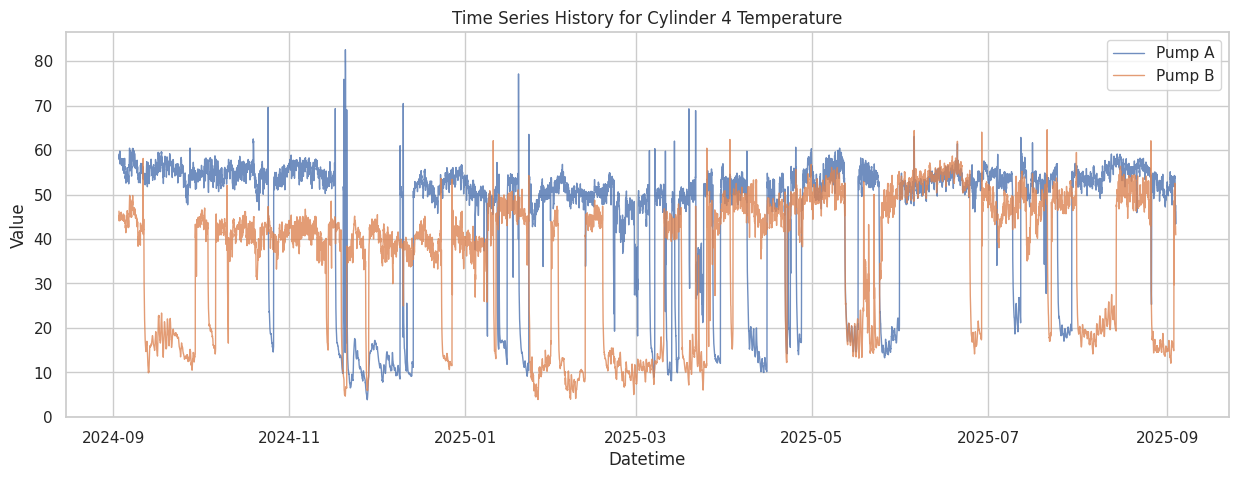

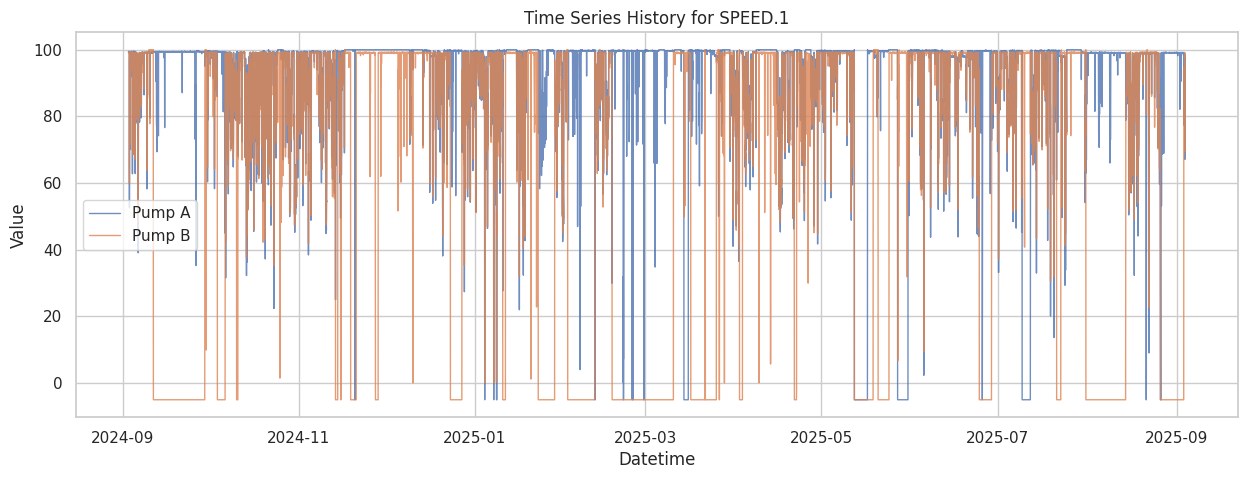

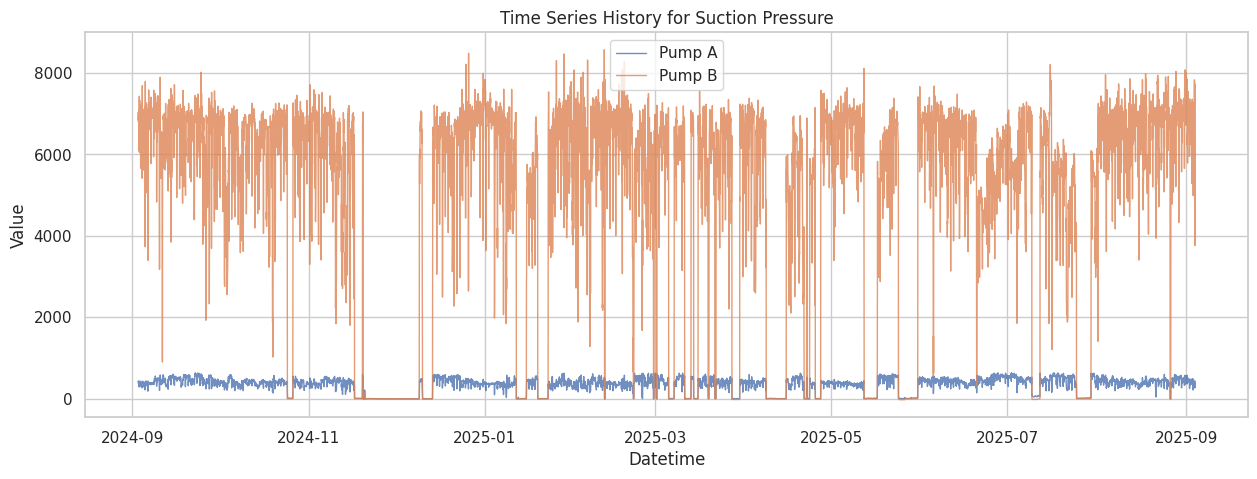

In [50]:
df_a_plt = df_combined[df_combined['Pump'] == 'Pump A'].set_index('Datetime')
df_b_plt = df_combined[df_combined['Pump'] == 'Pump B'].set_index('Datetime')

for col in numeric_cols:
    plt.figure(figsize=(15, 5))
    plt.plot(df_a_plt.index, df_a_plt[col], label='Pump A', alpha=0.8, linewidth=1)
    plt.plot(df_b_plt.index, df_b_plt[col], label='Pump B', alpha=0.8, linewidth=1)
    plt.title(f'Time Series History for {col}')
    plt.xlabel('Datetime')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



## 1.6. Feature Engineering: Rolling Statistics


In [51]:
window_size = 24
cols_to_exclude = ['Suction Pressure'] 
cols_to_roll = [col for col in numeric_cols if col not in cols_to_exclude]
df_rolling_features = df_combined[['Datetime', 'Pump'] + cols_to_exclude].copy()

for pump_name, group in df_combined.groupby('Pump'):
    pump_df = group.set_index('Datetime').sort_index()
    for col in cols_to_roll:
        rolling_mean = pump_df[col].rolling(window=window_size, min_periods=1).mean()
        rolling_std = pump_df[col].rolling(window=window_size, min_periods=1).std()
        df_rolling_features.loc[df_rolling_features['Pump'] == pump_name, f'{col}_rolling_mean_{window_size}h'] = rolling_mean.values
        df_rolling_features.loc[df_rolling_features['Pump'] == pump_name, f'{col}_rolling_std_{window_size}h'] = rolling_std.values

df_rolling_features.bfill(inplace=True)
df_rolling_features.ffill(inplace=True) 

df_a_model_ready = df_rolling_features[df_rolling_features['Pump'] == 'Pump A'].copy()
df_b_model_ready = df_rolling_features[df_rolling_features['Pump'] == 'Pump B'].copy()

print("--- Model-Ready DataFrame Head for Pump A ---")
df_a_model_ready.head()



--- Model-Ready DataFrame Head for Pump A ---


,Datetime,Pump,Suction Pressure,Cylinder 1 Temperature_rolling_mean_24h,Cylinder 1 Temperature_rolling_std_24h,Cylinder 2 Temperature_rolling_mean_24h,Cylinder 2 Temperature_rolling_std_24h,Cylinder 3_rolling_mean_24h,Cylinder 3_rolling_std_24h,Cylinder 3 Temperature_rolling_mean_24h,Cylinder 3 Temperature_rolling_std_24h,Cylinder 4 Temperature_rolling_mean_24h,Cylinder 4 Temperature_rolling_std_24h,SPEED.1_rolling_mean_24h,SPEED.1_rolling_std_24h
0,2024-09-03 00:00:00,Pump A,387.84,62.210,0.403051,52.910000,1.110158,6795.820000,169.755125,59.370,0.268701,57.870000,0.197990,99.400000,0.056569
1,2024-09-03 01:00:00,Pump A,434.91,61.925,0.403051,52.125000,1.110158,6915.855000,169.755125,59.560,0.268701,58.010000,0.197990,99.360000,0.056569
2,2024-09-03 02:00:00,Pump A,424.09,61.760,0.403609,52.123333,0.785005,6891.793333,127.064128,59.830,0.504777,58.333333,0.577264,99.396667,0.075056
3,2024-09-03 03:00:00,Pump A,423.87,61.595,0.466369,51.435000,1.518563,6906.815000,108.009862,59.865,0.418051,58.277500,0.484381,99.387500,0.063966
4,2024-09-03 04:00:00,Pump A,425.91,61.580,0.405278,51.204000,1.412915,6917.188000,96.372161,60.228,0.888774,58.278000,0.419488,99.410000,0.074833


# PART 2: A New, More Effective Modeling Strategy


Our previous attempt to predict 168 hours at once was too complex and yielded poor results. We will now reframe the problem to be more realistic and actionable:

**New Strategy:**
- **Input Sequence Length:** Use the last **72 hours** of data.
- **Prediction Window:** Predict the pump status for the next **72 hours**.

To support this, we will use a more powerful model architecture:
- **Bidirectional LSTM (BiLSTM):** Processes sequences forwards and backwards to capture richer patterns.
- **Learning Rate Scheduler:** Optimizes the training process for better convergence.


In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=12, num_layers=2, dropout=0.3):
        super(BidirectionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)

class PumpDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]



# PART 3: Training BiLSTM for Mud Pump A


### 3.1. Prepare and Sequence Data for Pump A


In [53]:
TARGET_COL_A = 'Mud Pump A'
df_merged_a = pd.merge(df_a_model_ready, df_a_original[['Datetime', TARGET_COL_A]], on='Datetime', how='inner')
df_merged_a = df_merged_a[df_merged_a[TARGET_COL_A] != 'Error']
df_merged_a.dropna(inplace=True)

feature_cols_a = [col for col in df_merged_a.columns if col not in ['Datetime', 'Pump', TARGET_COL_A]]
feature_values_a = df_merged_a[feature_cols_a].values
status_binary_a = (df_merged_a[TARGET_COL_A] == 'STOP').astype(int).values

INPUT_SEQUENCE_LENGTH = 72
PREDICTION_WINDOW = 72

X_list_a, y_list_a = [], []
for i in range(INPUT_SEQUENCE_LENGTH, len(feature_values_a) - PREDICTION_WINDOW):
    X_list_a.append(feature_values_a[i - INPUT_SEQUENCE_LENGTH : i])
    y_list_a.append(status_binary_a[i : i + PREDICTION_WINDOW])

X_a, y_a = np.array(X_list_a), np.array(y_list_a)
print(f"Pump A - X shape: {X_a.shape}, y shape: {y_a.shape}")



Pump A - X shape: (8641, 72, 13), y shape: (8641, 72)


### 3.2. Split, Scale, and Load Data for Pump A


In [54]:
train_size_a = int(len(X_a) * 0.8)
X_train_a, X_test_a = X_a[:train_size_a], X_a[train_size_a:]
y_train_a, y_test_a = y_a[:train_size_a], y_a[train_size_a:]

scaler_a = StandardScaler()
X_train_s_a = scaler_a.fit_transform(X_train_a.reshape(-1, X_a.shape[2])).reshape(X_train_a.shape)
X_test_s_a = scaler_a.transform(X_test_a.reshape(-1, X_a.shape[2])).reshape(X_test_a.shape)

train_loader_a = DataLoader(PumpDataset(X_train_s_a, y_train_a), batch_size=64, shuffle=False)
test_loader_a = DataLoader(PumpDataset(X_test_s_a, y_test_a), batch_size=64, shuffle=False)



### 3.3. Train the BiLSTM Model for Pump A


In [55]:
num_stops_a = np.sum(y_train_a == 1)
num_runs_a = np.sum(y_train_a == 0)
pos_weight_a = torch.tensor(num_runs_a / num_stops_a if num_stops_a > 0 else 1.0)
print(f"Pump A - Minority class ('STOP') weight: {pos_weight_a.item():.2f}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_a = BidirectionalLSTM(input_size=X_a.shape[2], output_size=PREDICTION_WINDOW).to(device)
criterion_a = nn.BCEWithLogitsLoss(pos_weight=pos_weight_a.to(device))
optimizer_a = optim.Adam(model_a.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_a = StepLR(optimizer_a, step_size=10, gamma=0.1)

epochs = 50
train_losses_a = []
print("\n--- Starting Training for Pump A ---")
for epoch in range(epochs):
    model_a.train()
    epoch_loss_a = 0
    for X_batch, y_batch in train_loader_a:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_a.zero_grad()
        outputs = model_a(X_batch)
        loss = criterion_a(outputs, y_batch)
        loss.backward()
        optimizer_a.step()
        epoch_loss_a += loss.item()
    
    avg_loss_a = epoch_loss_a / len(train_loader_a)
    train_losses_a.append(avg_loss_a)
    scheduler_a.step()
    if (epoch+1) % 5 == 0:
        print(f"  Epoch {epoch+1:02}/{epochs}, Avg Loss: {avg_loss_a:.4f}, LR: {scheduler_a.get_last_lr()[0]:.6f}")
print("--- Training Finished for Pump A ---")



Pump A - Minority class ('STOP') weight: 3.29

--- Starting Training for Pump A ---
  Epoch 05/50, Avg Loss: 0.7278, LR: 0.001000
  Epoch 10/50, Avg Loss: 0.7075, LR: 0.000100
  Epoch 15/50, Avg Loss: 0.6739, LR: 0.000100
  Epoch 20/50, Avg Loss: 0.6631, LR: 0.000010
  Epoch 25/50, Avg Loss: 0.6534, LR: 0.000010
  Epoch 30/50, Avg Loss: 0.6510, LR: 0.000001
  Epoch 35/50, Avg Loss: 0.6494, LR: 0.000001
  Epoch 40/50, Avg Loss: 0.6499, LR: 0.000000
  Epoch 45/50, Avg Loss: 0.6493, LR: 0.000000
  Epoch 50/50, Avg Loss: 0.6494, LR: 0.000000
--- Training Finished for Pump A ---


### 3.4. Visualize Training Loss for Pump A


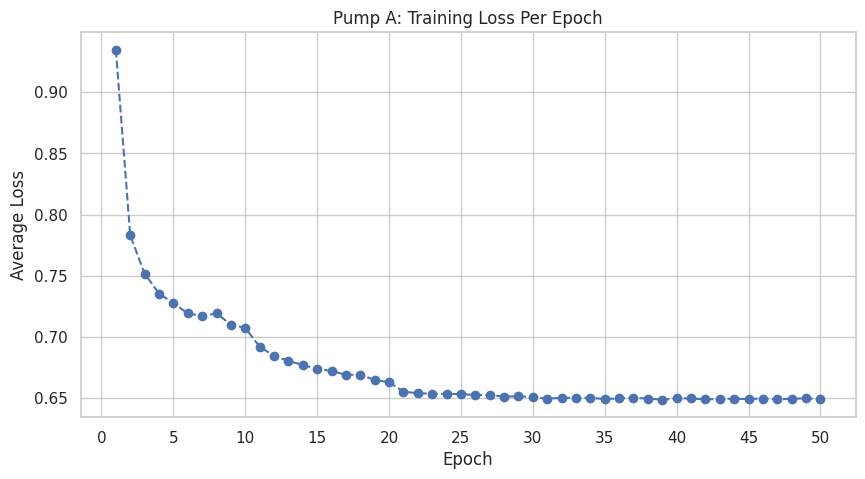

In [56]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses_a, marker='o', linestyle='--')
plt.title('Pump A: Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(range(0, epochs + 1, 5))
plt.grid(True)
plt.show()

### 3.5. Evaluate Model for Pump A



--- Pump A: Classification Report (Hourly Level) ---
              precision    recall  f1-score   support

     RUN (0)       0.95      0.95      0.95    110376
    STOP (1)       0.59      0.57      0.58     14112

    accuracy                           0.91    124488
   macro avg       0.77      0.76      0.77    124488
weighted avg       0.91      0.91      0.91    124488



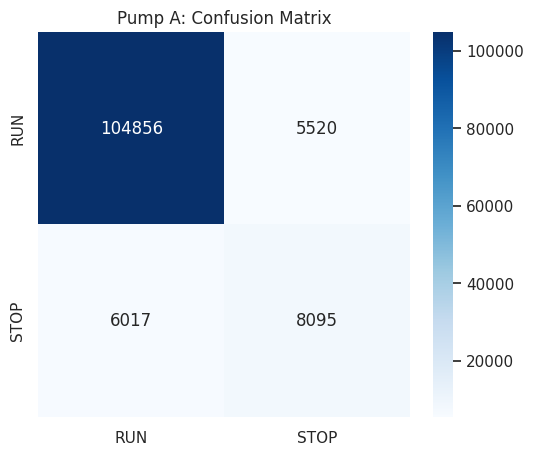

In [57]:
model_a.eval()
all_preds_proba_a, all_targets_a = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader_a:
        outputs = model_a(X_batch.to(device))
        all_preds_proba_a.append(torch.sigmoid(outputs).cpu().numpy())
        all_targets_a.append(y_batch.numpy())

y_pred_proba_a = np.concatenate(all_preds_proba_a)
y_test_np_a = np.concatenate(all_targets_a)
y_pred_flat_a = (y_pred_proba_a > 0.5).astype(int).flatten()
y_test_flat_a = y_test_np_a.flatten()

print("\n--- Pump A: Classification Report (Hourly Level) ---")
print(classification_report(y_test_flat_a, y_pred_flat_a, target_names=['RUN (0)', 'STOP (1)']))

cm_a = confusion_matrix(y_test_flat_a, y_pred_flat_a)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Blues', xticklabels=['RUN', 'STOP'], yticklabels=['RUN', 'STOP'])
plt.title('Pump A: Confusion Matrix')
plt.show()

# PART 4: Training BiLSTM for Mud Pump B


### 4.1. Prepare and Sequence Data for Pump B


In [58]:
TARGET_COL_B = 'Mud Pump B'
df_merged_b = pd.merge(df_b_model_ready, df_b_original[['Datetime', TARGET_COL_B]], on='Datetime', how='inner')
df_merged_b = df_merged_b[df_merged_b[TARGET_COL_B] != 'Error']
df_merged_b.dropna(inplace=True)

feature_cols_b = [col for col in df_merged_b.columns if col not in ['Datetime', 'Pump', TARGET_COL_B]]
feature_values_b = df_merged_b[feature_cols_b].values
status_binary_b = (df_merged_b[TARGET_COL_B] == 'STOP').astype(int).values

X_list_b, y_list_b = [], []
for i in range(INPUT_SEQUENCE_LENGTH, len(feature_values_b) - PREDICTION_WINDOW):
    X_list_b.append(feature_values_b[i - INPUT_SEQUENCE_LENGTH : i])
    y_list_b.append(status_binary_b[i : i + PREDICTION_WINDOW])

X_b, y_b = np.array(X_list_b), np.array(y_list_b)
print(f"Pump B - X shape: {X_b.shape}, y shape: {y_b.shape}")



Pump B - X shape: (8643, 72, 13), y shape: (8643, 72)


### 4.2. Split, Scale, and Load Data for Pump B


In [59]:
train_size_b = int(len(X_b) * 0.8)
X_train_b, X_test_b = X_b[:train_size_b], X_b[train_size_b:]
y_train_b, y_test_b = y_b[:train_size_b], y_b[train_size_b:]

scaler_b = StandardScaler()
X_train_s_b = scaler_b.fit_transform(X_train_b.reshape(-1, X_b.shape[2])).reshape(X_train_b.shape)
X_test_s_b = scaler_b.transform(X_test_b.reshape(-1, X_b.shape[2])).reshape(X_test_b.shape)

train_loader_b = DataLoader(PumpDataset(X_train_s_b, y_train_b), batch_size=64, shuffle=False)
test_loader_b = DataLoader(PumpDataset(X_test_s_b, y_test_b), batch_size=64, shuffle=False)



### 4.3. Train the BiLSTM Model for Pump B


In [60]:
num_stops_b = np.sum(y_train_b == 1)
num_runs_b = np.sum(y_train_b == 0)
pos_weight_b = torch.tensor(num_runs_b / num_stops_b if num_stops_b > 0 else 1.0)
print(f"Pump B - Minority class ('STOP') weight: {pos_weight_b.item():.2f}")

model_b = BidirectionalLSTM(input_size=X_b.shape[2], output_size=PREDICTION_WINDOW).to(device)
criterion_b = nn.BCEWithLogitsLoss(pos_weight=pos_weight_b.to(device))
optimizer_b = optim.Adam(model_b.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_b = StepLR(optimizer_b, step_size=10, gamma=0.1)

train_losses_b = []
print("\n--- Starting Training for Pump B ---")
for epoch in range(epochs):
    model_b.train()
    epoch_loss_b = 0
    for X_batch, y_batch in train_loader_b:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_b.zero_grad()
        outputs = model_b(X_batch)
        loss = criterion_b(outputs, y_batch)
        loss.backward()
        optimizer_b.step()
        epoch_loss_b += loss.item()
        
    avg_loss_b = epoch_loss_b / len(train_loader_b)
    train_losses_b.append(avg_loss_b)
    scheduler_b.step()
    if (epoch+1) % 5 == 0:
        print(f"  Epoch {epoch+1:02}/{epochs}, Avg Loss: {avg_loss_b:.4f}, LR: {scheduler_b.get_last_lr()[0]:.6f}")
print("--- Training Finished for Pump B ---")



Pump B - Minority class ('STOP') weight: 2.29

--- Starting Training for Pump B ---
  Epoch 05/50, Avg Loss: 0.6170, LR: 0.001000
  Epoch 10/50, Avg Loss: 0.6079, LR: 0.000100
  Epoch 15/50, Avg Loss: 0.5716, LR: 0.000100
  Epoch 20/50, Avg Loss: 0.5613, LR: 0.000010
  Epoch 25/50, Avg Loss: 0.5571, LR: 0.000010
  Epoch 30/50, Avg Loss: 0.5556, LR: 0.000001
  Epoch 35/50, Avg Loss: 0.5561, LR: 0.000001
  Epoch 40/50, Avg Loss: 0.5562, LR: 0.000000
  Epoch 45/50, Avg Loss: 0.5561, LR: 0.000000
  Epoch 50/50, Avg Loss: 0.5560, LR: 0.000000
--- Training Finished for Pump B ---


### 4.4. Visualize Training Loss for Pump B


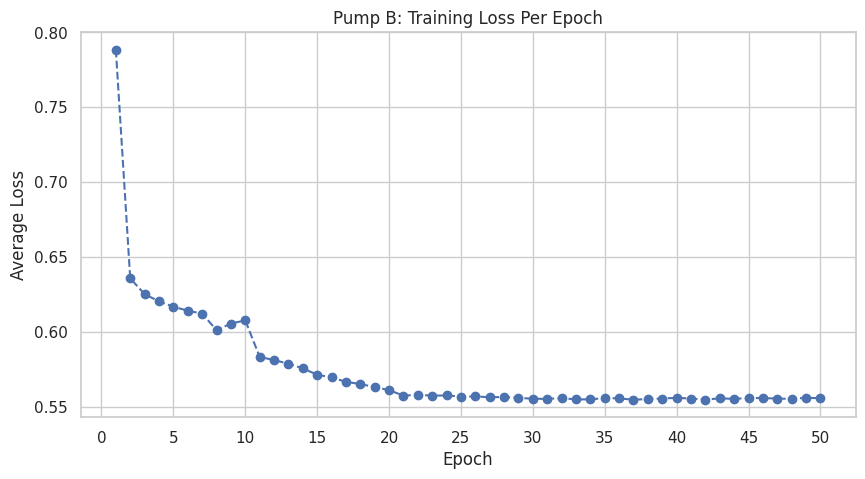

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses_b, marker='o', linestyle='--')
plt.title('Pump B: Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.xticks(range(0, epochs + 1, 5))
plt.grid(True)
plt.show()



### 4.5. Evaluate Model for Pump B



--- Pump B: Classification Report (Hourly Level) ---
              precision    recall  f1-score   support

     RUN (0)       0.87      0.90      0.88     78405
    STOP (1)       0.81      0.77      0.79     46083

    accuracy                           0.85    124488
   macro avg       0.84      0.83      0.84    124488
weighted avg       0.85      0.85      0.85    124488



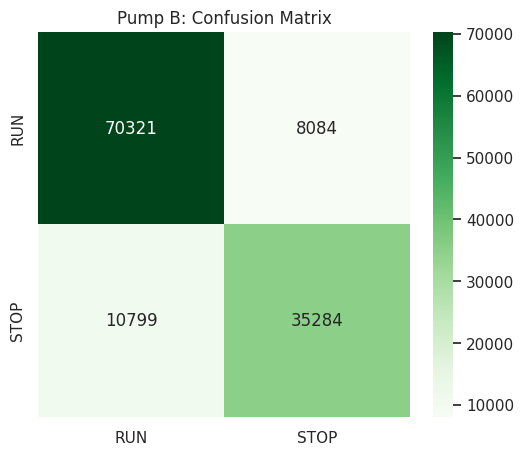

In [62]:
model_b.eval()
all_preds_proba_b, all_targets_b = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader_b:
        outputs = model_b(X_batch.to(device))
        all_preds_proba_b.append(torch.sigmoid(outputs).cpu().numpy())
        all_targets_b.append(y_batch.numpy())

y_pred_proba_b = np.concatenate(all_preds_proba_b)
y_test_np_b = np.concatenate(all_targets_b)
y_pred_flat_b = (y_pred_proba_b > 0.5).astype(int).flatten()
y_test_flat_b = y_test_np_b.flatten()

print("\n--- Pump B: Classification Report (Hourly Level) ---")
print(classification_report(y_test_flat_b, y_pred_flat_b, target_names=['RUN (0)', 'STOP (1)']))

cm_b = confusion_matrix(y_test_flat_b, y_pred_flat_b)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greens', xticklabels=['RUN', 'STOP'], yticklabels=['RUN', 'STOP'])
plt.title('Pump B: Confusion Matrix')
plt.show()



In [66]:
import random

def visualize_pump_forecasts(y_true, y_pred_prob, pump_name, prediction_window=72, num_samples=3):
    """
    Plots specific examples where the pump actually stopped to see if the model predicted it.
    """
    # 1. Find indices where a failure (STOP=1) actually occurred in the test set
    # Summing along axis 1 tells us how many '1's are in the 72-hour window
    samples_with_failure = np.where(y_true.sum(axis=1) > 0)[0]
    
    if len(samples_with_failure) == 0:
        print(f"No failures found in the test set for {pump_name}.")
        return

    # 2. Select a few random samples from those failures to visualize
    # If we have fewer than requested samples, just take what we have
    n = min(len(samples_with_failure), num_samples)
    sample_indices = np.random.choice(samples_with_failure, n, replace=False)
    
    print(f"--- Visualizing {n} failure scenarios for {pump_name} ---")

    for i, idx in enumerate(sample_indices):
        plt.figure(figsize=(15, 5))
        
        # Create X-axis (Hours 1 to 72)
        hours = range(1, prediction_window + 1)
        
        # Plot Actual Status (Black Dashed Line)
        plt.plot(hours, y_true[idx], label='Actual Status (1=STOP)', 
                 color='black', linestyle='--', linewidth=2)
        
        # Plot Predicted Probability (Colored Line)
        # Pump A uses Blue/Red, Pump B uses Green/Red
        color = 'tab:blue' if 'A' in pump_name else 'tab:green'
        plt.plot(hours, y_pred_prob[idx], label='Predicted Probability', 
                 color=color, linewidth=2, alpha=0.8)
        
        # Fill area under probability for better visibility
        plt.fill_between(hours, y_pred_prob[idx], color=color, alpha=0.2)
        
        # Add Threshold Line
        plt.axhline(y=0.5, color='red', linestyle=':', alpha=0.5, label='Decision Threshold (0.5)')
        
        plt.title(f'{pump_name}: 72-Hour Forecast | Test Sample Index: {idx}')
        plt.xlabel('Hours into Future')
        plt.ylabel('Probability / Status')
        plt.ylim(-0.1, 1.1)
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.show()



Pump A Matrix Shape: (1729, 72)
--- Visualizing 3 failure scenarios for Pump A ---


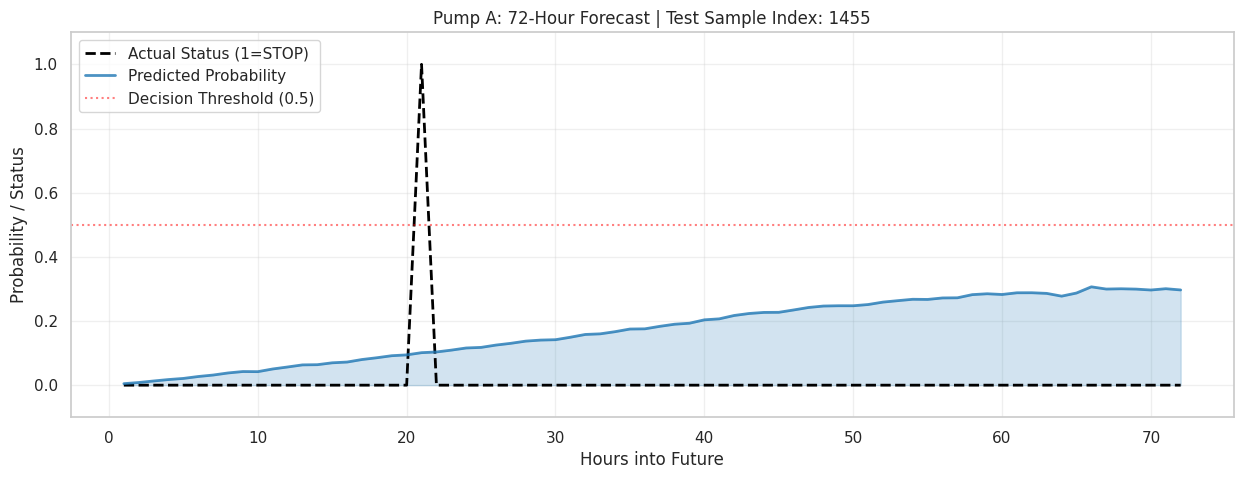

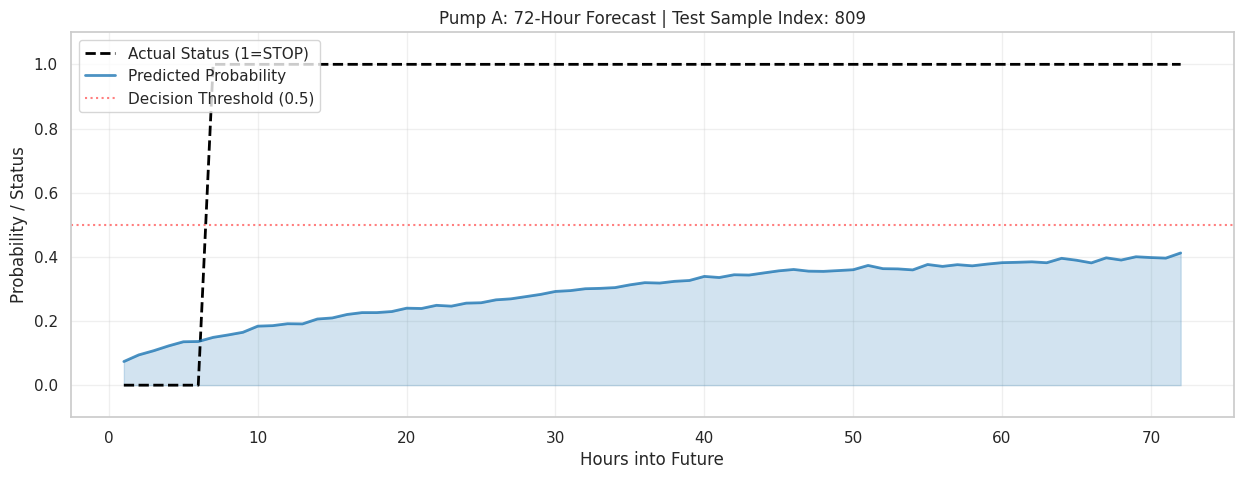

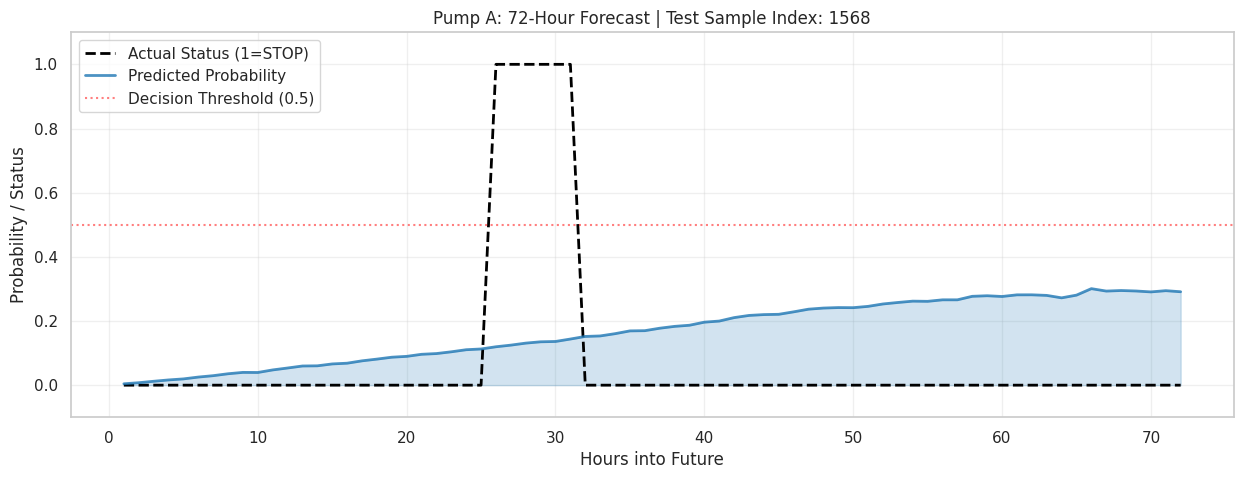

In [71]:
y_pred_proba_matrix_a = np.concatenate(all_preds_proba_a, axis=0)
y_test_matrix_a = np.concatenate(all_targets_a, axis=0)

# Double check the shape (It should be [Total_Test_Samples, 72])
print(f"Pump A Matrix Shape: {y_pred_proba_matrix_a.shape}")

visualize_pump_forecasts(y_test_matrix_a, y_pred_proba_matrix_a, 'Pump A', PREDICTION_WINDOW)


Pump B Matrix Shape: (1729, 72)
--- Visualizing 3 failure scenarios for Pump B ---


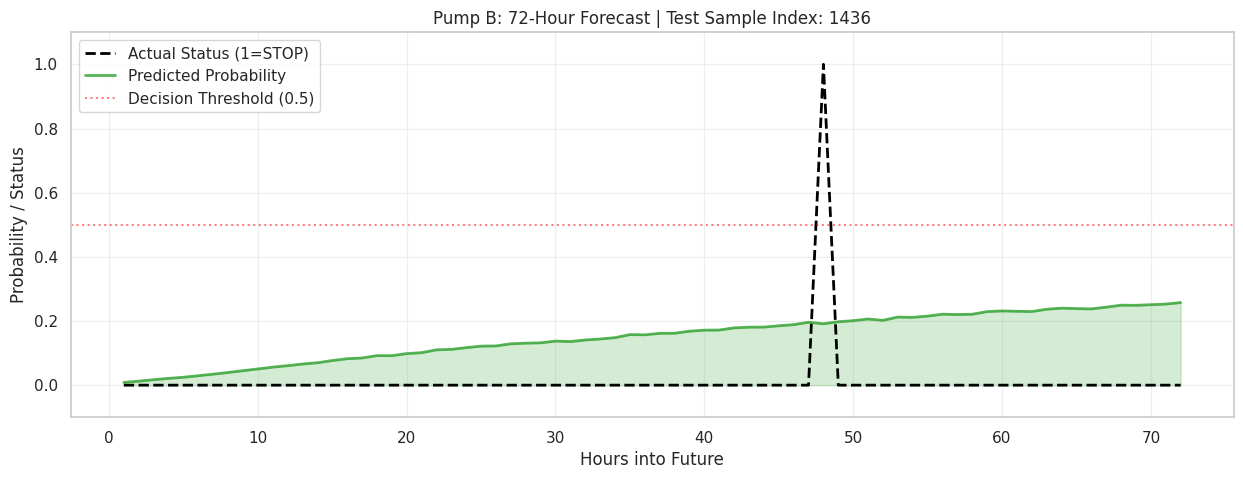

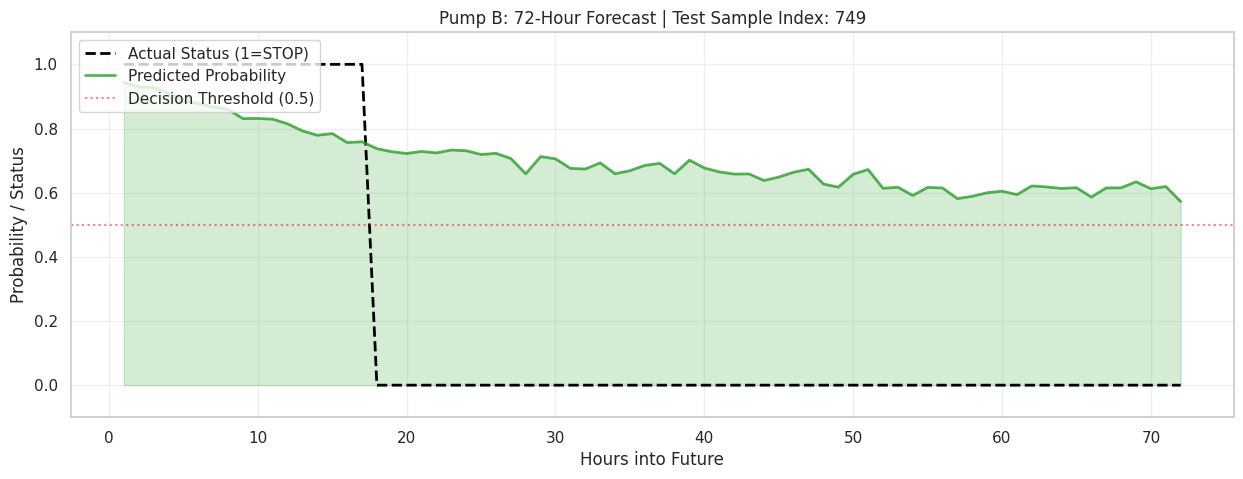

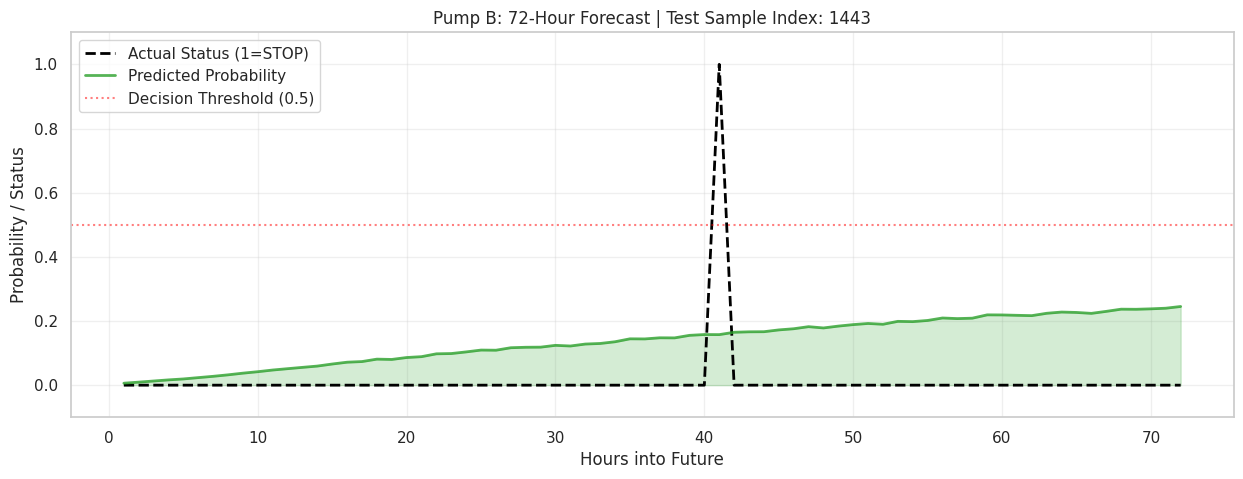

In [72]:
y_pred_proba_matrix_b = np.concatenate(all_preds_proba_b, axis=0)
y_test_matrix_b = np.concatenate(all_targets_b, axis=0)

# Double check the shape
print(f"Pump B Matrix Shape: {y_pred_proba_matrix_b.shape}")

visualize_pump_forecasts(y_test_matrix_b, y_pred_proba_matrix_b, 'Pump B', PREDICTION_WINDOW)

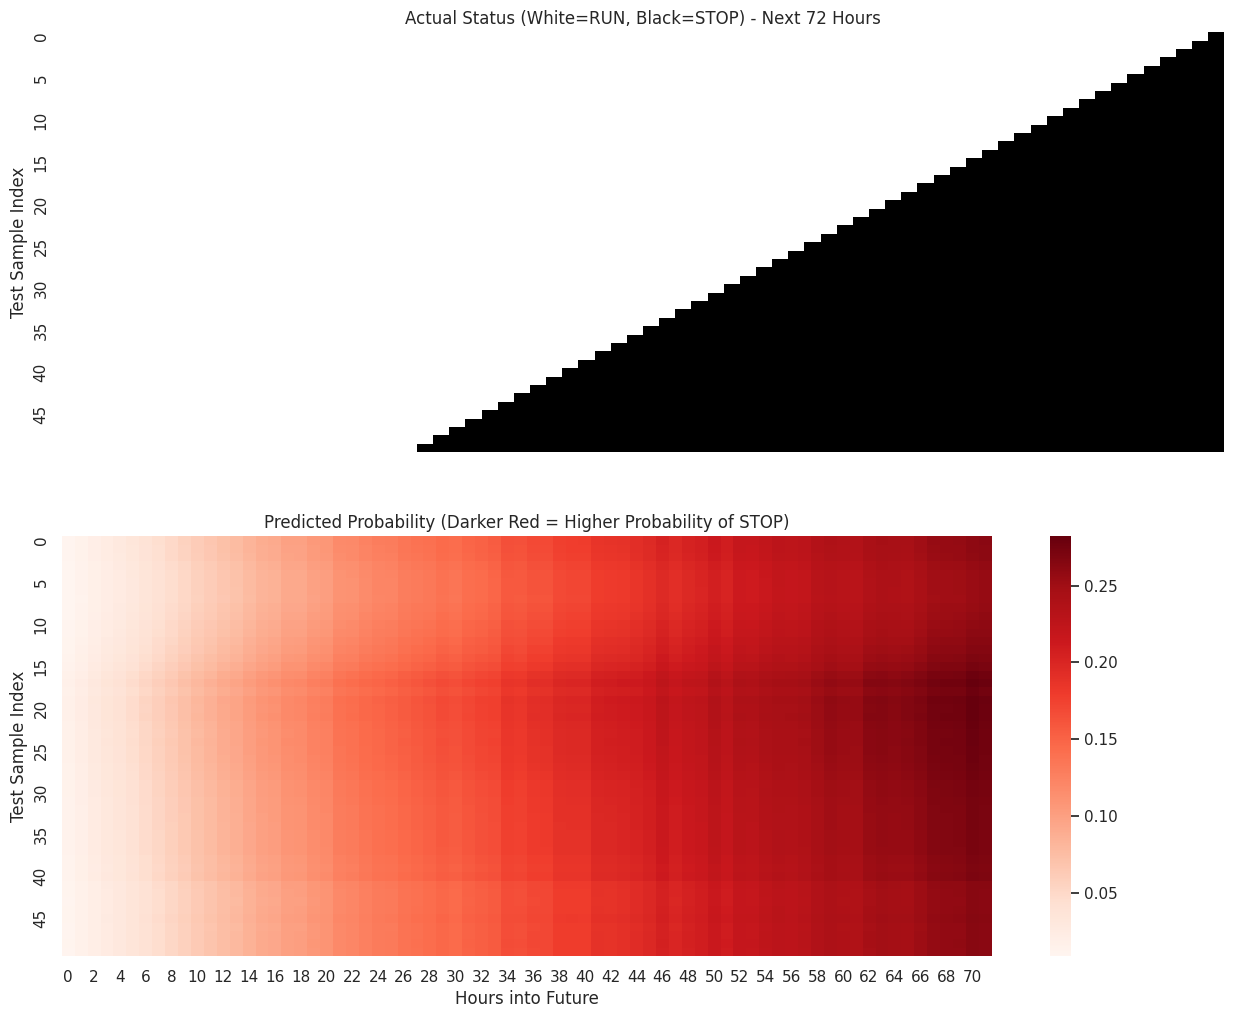

In [73]:
subset_size = 50 
start_idx = 0

# Find a section with failures to make the plot interesting
active_indices = np.where(y_test_matrix_b.sum(axis=1) > 0)[0]
if len(active_indices) > 0:
    start_idx = active_indices[0]

# Slice the data
heatmap_truth = y_test_matrix_b[start_idx : start_idx + subset_size]
heatmap_pred = y_pred_proba_matrix_b[start_idx : start_idx + subset_size]

fig, ax = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot 1: Actuals
sns.heatmap(heatmap_truth, cmap='Greys', cbar=False, ax=ax[0], yticklabels=5)
ax[0].set_title(f'Actual Status (White=RUN, Black=STOP) - Next 72 Hours')
ax[0].set_ylabel('Test Sample Index')

# Plot 2: Predictions
sns.heatmap(heatmap_pred, cmap='Reds', ax=ax[1], yticklabels=5)
ax[1].set_title(f'Predicted Probability (Darker Red = Higher Probability of STOP)')
ax[1].set_xlabel('Hours into Future')
ax[1].set_ylabel('Test Sample Index')

plt.show()

In [74]:
# ensure we are using the concatenated (fixed) arrays
y_pred_proba_matrix_b = np.concatenate(all_preds_proba_b, axis=0)
y_test_matrix_b = np.concatenate(all_targets_b, axis=0)

print(f"Test Set Shape: {y_test_matrix_b.shape}")

# Extract the continuous timeline
# Since windows shift by 1 hour, the first element of each window 
# forms the continuous sequence for the "Next Hour" prediction.
actual_timeline = y_test_matrix_b[:, 0]
pred_timeline_1h = y_pred_proba_matrix_b[:, 0]

# We can also look at "24 Hours Ahead" predictions to see if the model gives early warnings
# We shift the array because the prediction made at time 't' for 't+24' should be plotted at 't+24'
pred_timeline_24h = np.full_like(actual_timeline, np.nan, dtype=float)
if y_pred_proba_matrix_b.shape[1] >= 24:
    # Take the 24th column (index 23)
    raw_24h = y_pred_proba_matrix_b[:, 23]
    # Shift it forward by 23 steps so it aligns with the actual event time
    pred_timeline_24h[23:] = raw_24h[:-23]

Test Set Shape: (1729, 72)


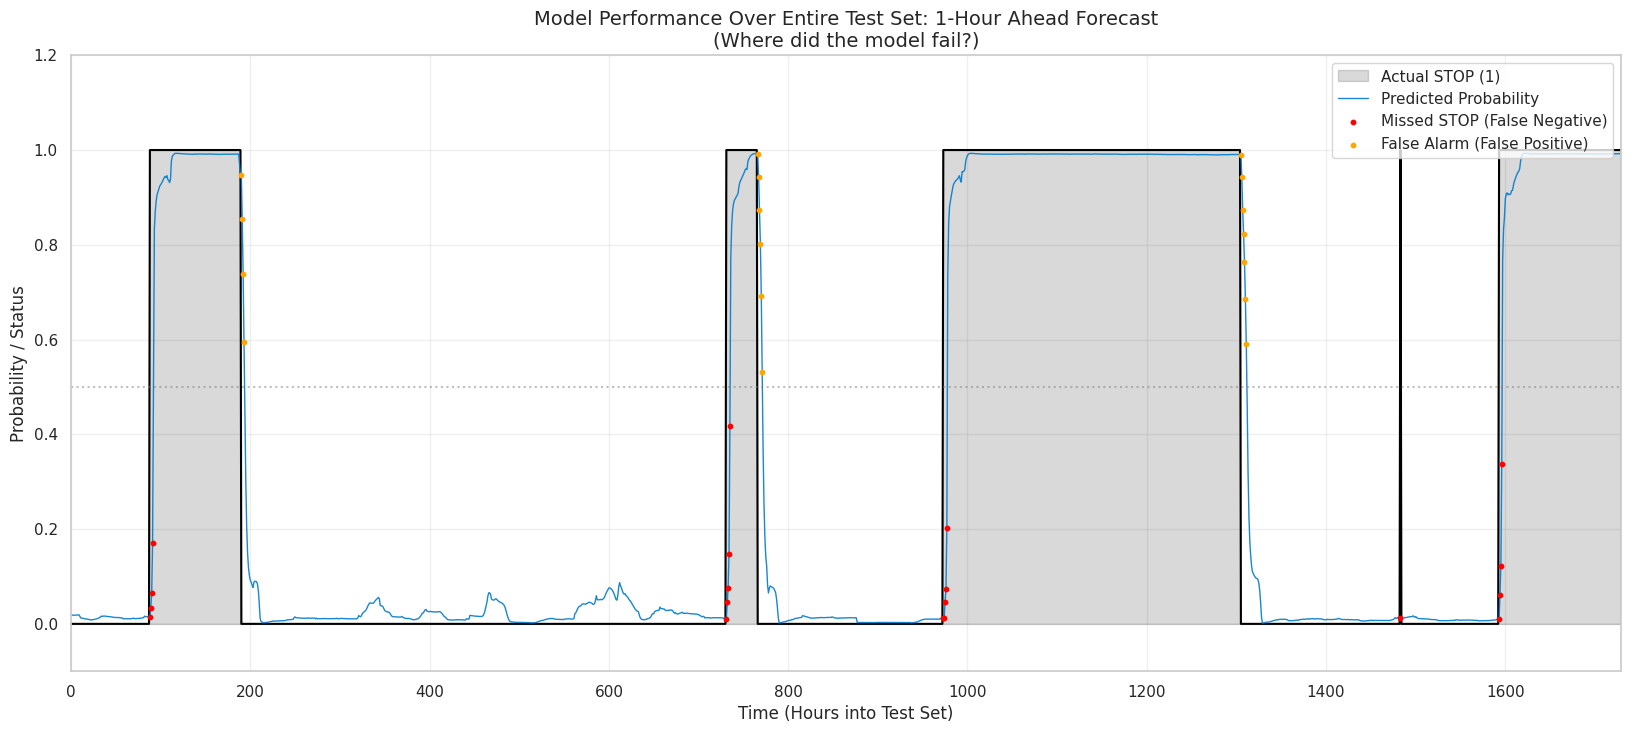

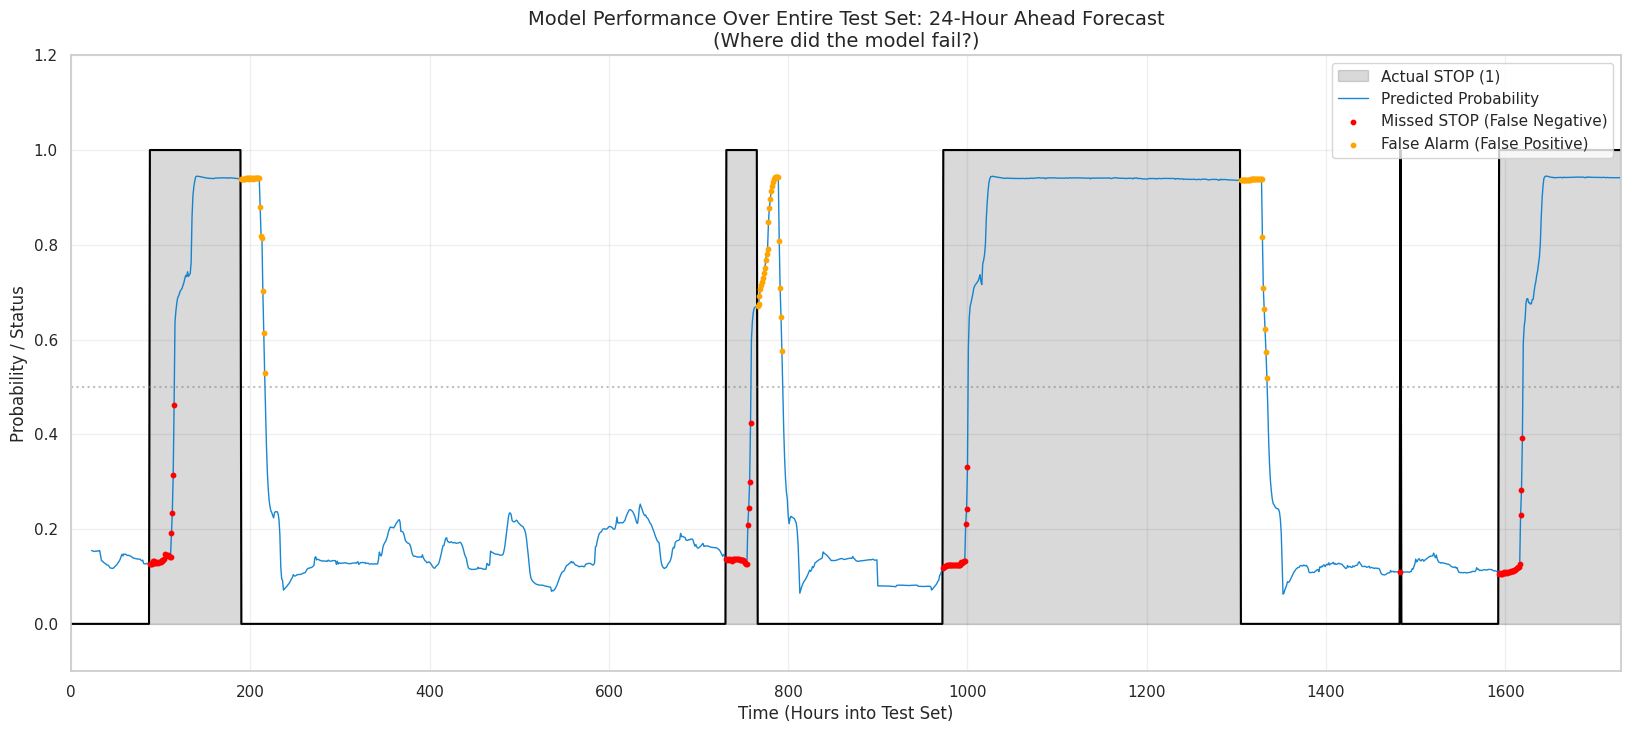

In [75]:
def plot_full_timeline_performance(actual, pred, title_suffix=""):
    plt.figure(figsize=(20, 8))
    
    # 1. Plot Actual Status (Black Line)
    # We fill the area under the curve for better visibility of STOP events
    plt.fill_between(range(len(actual)), actual, color='black', alpha=0.15, label='Actual STOP (1)')
    plt.plot(actual, color='black', linewidth=1.5)
    
    # 2. Plot Predicted Probability (Blue Line)
    plt.plot(pred, color='#007acc', linewidth=1, alpha=0.9, label='Predicted Probability')
    
    # 3. Highlight Errors
    # Create boolean masks for errors
    threshold = 0.5
    binary_pred = (pred > threshold).astype(int)
    
    # False Negatives (Missed Stops): Actual=1, Pred=0
    missed_mask = (actual == 1) & (binary_pred == 0)
    # False Positives (False Alarms): Actual=0, Pred=1
    false_alarm_mask = (actual == 0) & (binary_pred == 1)

    # We use scatter points to highlight specific hours of failure
    if np.any(missed_mask):
        plt.scatter(np.where(missed_mask)[0], pred[missed_mask], 
                    color='red', s=10, label='Missed STOP (False Negative)', zorder=5)
        
    if np.any(false_alarm_mask):
        plt.scatter(np.where(false_alarm_mask)[0], pred[false_alarm_mask], 
                    color='orange', s=10, label='False Alarm (False Positive)', zorder=5)

    # Add Threshold Line
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
    
    plt.title(f'Model Performance Over Entire Test Set: {title_suffix}\n(Where did the model fail?)', fontsize=14)
    plt.xlabel('Time (Hours into Test Set)')
    plt.ylabel('Probability / Status')
    plt.legend(loc='upper right', frameon=True)
    plt.xlim(0, len(actual))
    plt.ylim(-0.1, 1.2)
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Plot 1: How well does it predict the IMMEDIATE next hour? ---
plot_full_timeline_performance(actual_timeline, pred_timeline_1h, title_suffix="1-Hour Ahead Forecast")

# --- Plot 2: How well does it predict 24 HOURS in advance? ---
# (Note: NaN values at the start are ignored)
plot_full_timeline_performance(actual_timeline, pred_timeline_24h, title_suffix="24-Hour Ahead Forecast")

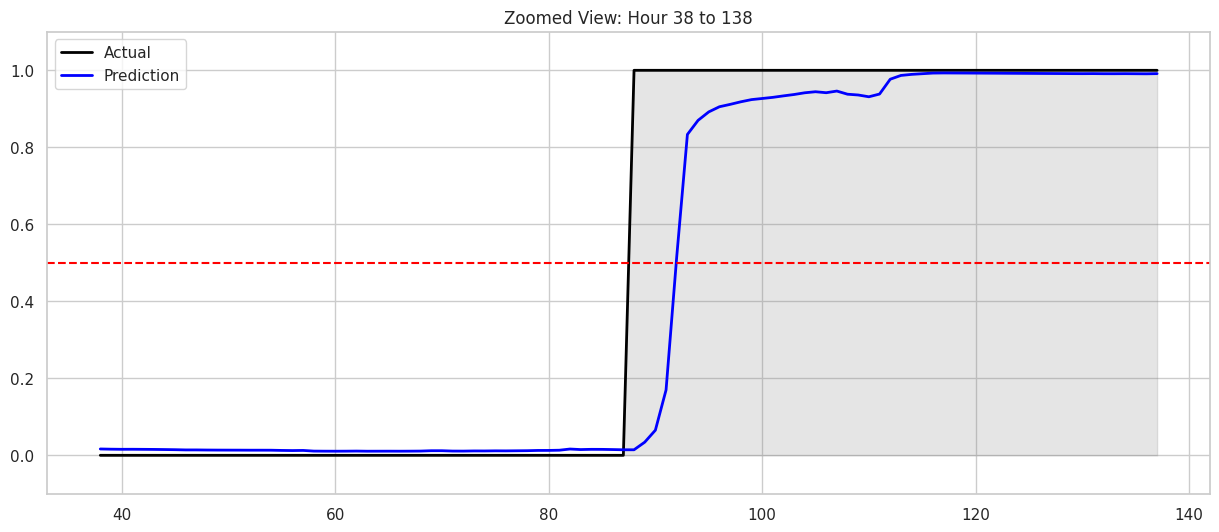

In [76]:
def plot_zoomed_segment(start_hour, end_hour, actual, pred):
    # Clip indices
    start_hour = max(0, start_hour)
    end_hour = min(len(actual), end_hour)
    
    segment_actual = actual[start_hour:end_hour]
    segment_pred = pred[start_hour:end_hour]
    
    plt.figure(figsize=(15, 6))
    plt.plot(range(start_hour, end_hour), segment_actual, color='black', label='Actual', linewidth=2)
    plt.plot(range(start_hour, end_hour), segment_pred, color='blue', label='Prediction', linewidth=2)
    
    plt.axhline(0.5, color='red', linestyle='--')
    plt.fill_between(range(start_hour, end_hour), segment_actual, color='gray', alpha=0.2)
    
    plt.title(f'Zoomed View: Hour {start_hour} to {end_hour}')
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Find the first failure and zoom in on it
failures = np.where(actual_timeline == 1)[0]
if len(failures) > 0:
    first_failure = failures[0]
    # Show 100 hours before and after the first failure
    plot_zoomed_segment(first_failure - 50, first_failure + 50, actual_timeline, pred_timeline_1h)
else:
    print("No failures in test set to zoom in on.")

--- Processing Pump A (Test Set Shape: (1729, 72)) ---


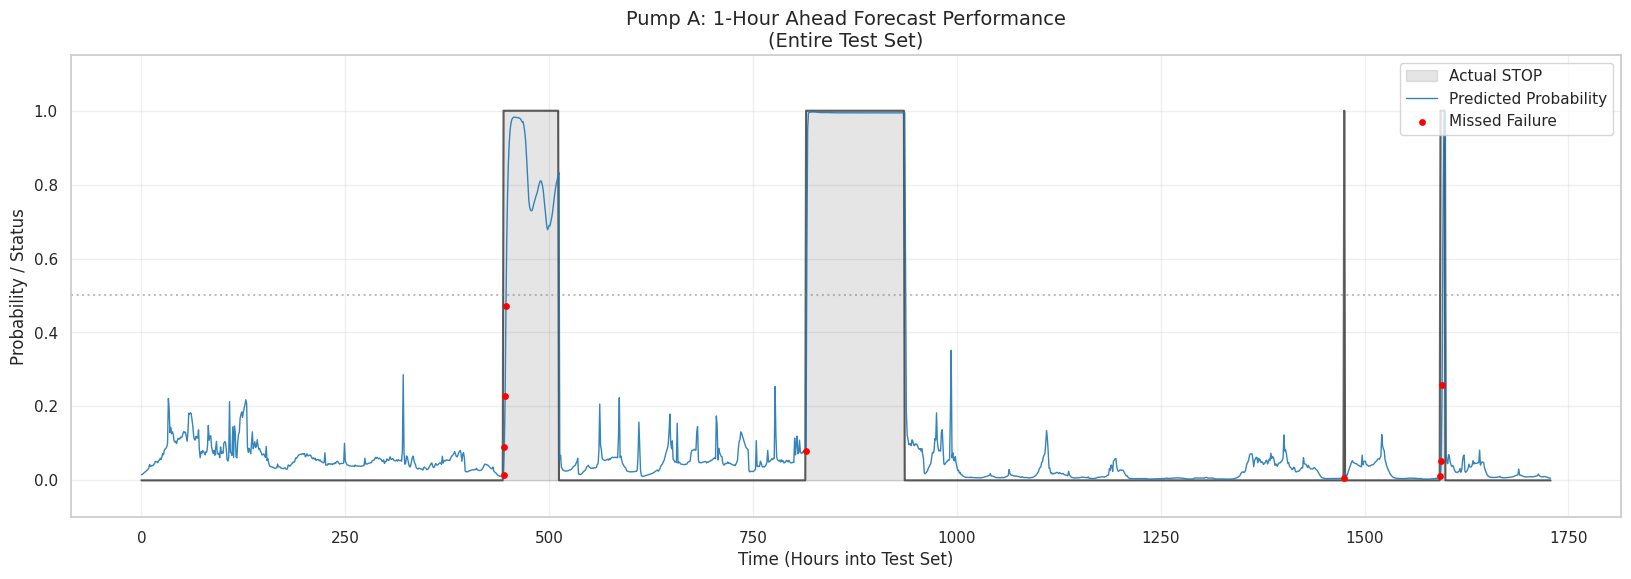

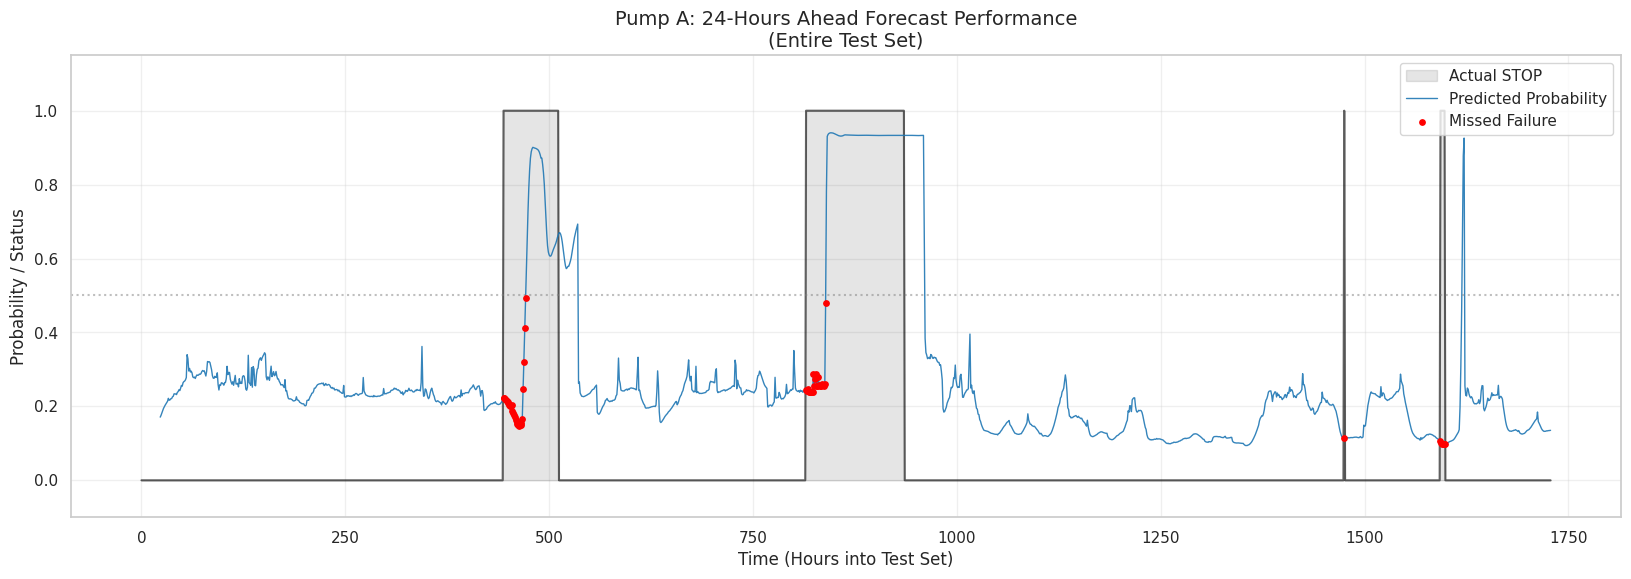

--- Processing Pump B (Test Set Shape: (1729, 72)) ---


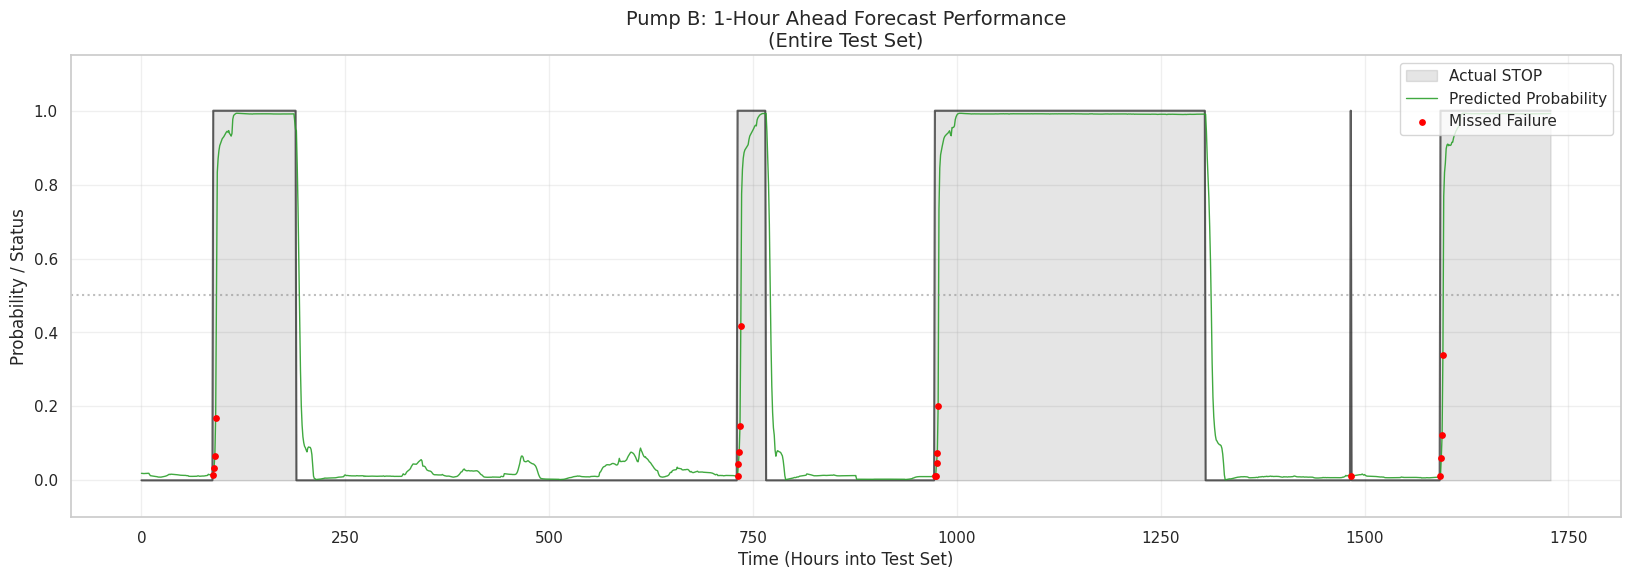

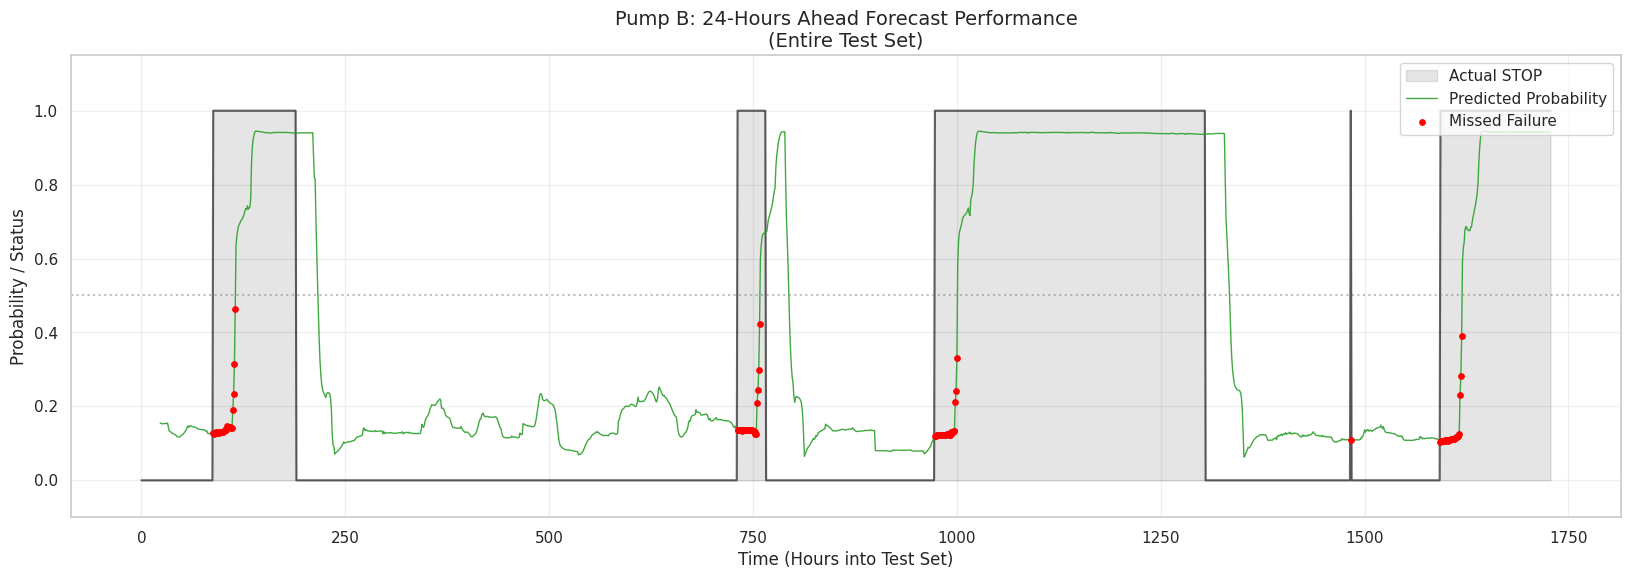

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_full_timeline(actual, pred, pump_name, horizon_label):
    """
    Plots the entire test set timeline for a specific Pump and Prediction Horizon.
    """
    plt.figure(figsize=(20, 6))
    
    # 1. Plot Actual Status (Black Line & Gray Fill)
    plt.fill_between(range(len(actual)), actual, color='black', alpha=0.1, label='Actual STOP')
    plt.plot(actual, color='black', linewidth=1.5, alpha=0.6)
    
    # 2. Plot Predicted Probability (Color depends on Pump)
    color = 'tab:blue' if 'A' in pump_name else 'tab:green'
    plt.plot(pred, color=color, linewidth=1, alpha=0.9, label='Predicted Probability')
    
    # 3. Highlight Missed Stops (False Negatives)
    # Where Actual is 1 (STOP) but Model predicts < 0.5 (RUN)
    missed = (actual == 1) & (pred < 0.5)
    if np.any(missed):
        plt.scatter(np.where(missed)[0], pred[missed], color='red', s=15, label='Missed Failure', zorder=5)

    # 4. Formatting
    plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
    plt.title(f'{pump_name}: {horizon_label} Forecast Performance\n(Entire Test Set)', fontsize=14)
    plt.xlabel('Time (Hours into Test Set)')
    plt.ylabel('Probability / Status')
    plt.legend(loc='upper right')
    plt.ylim(-0.1, 1.15)
    plt.grid(True, alpha=0.3)
    plt.show()

def process_and_plot_pump(pred_list, target_list, pump_name):
    """
    1. Concatenates the batches (Fixes the shape error).
    2. Extracts 1-hour ahead and 24-hour ahead predictions.
    3. Plots them.
    """
    # 1. Fix Shapes using Concatenate
    y_pred_mat = np.concatenate(pred_list, axis=0)
    y_true_mat = np.concatenate(target_list, axis=0)
    
    print(f"--- Processing {pump_name} (Test Set Shape: {y_true_mat.shape}) ---")

    # 2. Extract Timelines
    # Column 0 = The prediction for the very next hour (t+1)
    actual_timeline = y_true_mat[:, 0] 
    pred_1h = y_pred_mat[:, 0]
    
    # Column 23 = The prediction for 24 hours later (t+24)
    # We shift it so it aligns visually with the event time
    pred_24h = np.full_like(actual_timeline, np.nan, dtype=float)
    if y_pred_mat.shape[1] >= 24:
        pred_24h[23:] = y_pred_mat[:-23, 23]

    # 3. Generate Plots
    # Plot 1: Short Term (1 Hour Ahead)
    plot_full_timeline(actual_timeline, pred_1h, pump_name, "1-Hour Ahead")
    
    # Plot 2: Long Term (24 Hours Ahead)
    # Good for seeing if the model detects issues in advance
    plot_full_timeline(actual_timeline, pred_24h, pump_name, "24-Hours Ahead")


process_and_plot_pump(all_preds_proba_a, all_targets_a, "Pump A")

process_and_plot_pump(all_preds_proba_b, all_targets_b, "Pump B")